In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [254]:
# function to load the data files with the model and the betting vendor precitions for the last season
def load_data(file1, file2):
    model_data = pd.read_csv(file1) # loading of the dataset with the model predcitions
    betting_odds_data = pd.read_csv(file2) # loading of the dataset with the odd predictions
    print(betting_odds_data)
    return model_data, betting_odds_data

In [255]:
# function to translate the game results into numerical values
def convert_ftr(result: str):
    if result == "D":
        return 1
    elif result == "H":
        return 2
    elif result == "A":
        return 0
    else:
        return None

In [256]:
# function to only select the columns necessary for the comparison of our model and the betting vendors
# calling functions to harmonize the dataframes
def reduce_data(model_data, betting_odds_data):
    model_data_reduced = model_data[[
        'FTR', 'predictedResults', 'ProbAwayWin', 'ProbDraw', 'ProbHomeWin'
    ]]
    betting_odds_data_reduced = betting_odds_data[[
        'Betting_Prediction', 'Betting_Prediction_Probability', 'MaxHome', 'MaxAway', 'MaxDraw'
    ]]
    betting_odds_data_reduced[
        'Betting_Prediction'] = betting_odds_data_reduced[
            'Betting_Prediction'].apply(convert_ftr) # translation of the game results into numerical values
    betting_odds_data_reduced = betting_odds_data_reduced[-216:].reset_index() # only selecting the games from the last season
    return model_data_reduced, betting_odds_data_reduced

In [257]:
# function to get the probabilities for the result predicted from the model
def get_model_prediction_probability(model_data_reduced):
    result_probability = []
    z = 0
    while z < len(model_data_reduced): # loop to get the probability for the predicted result
        if model_data_reduced['predictedResults'][z] == 0:
            result_probability.append(model_data_reduced['ProbAwayWin'][z])
        if model_data_reduced['predictedResults'][z] == 1:
            result_probability.append(model_data_reduced['ProbDraw'][z])
        if model_data_reduced['predictedResults'][z] == 2:
            result_probability.append(model_data_reduced['ProbHomeWin'][z])
        z += 1
    return result_probability

In [258]:
def get_odd_prediction(data_model_reduced):
    erg_prob = []
    z = 0
    while z < len(data_model_reduced
                  ):  # loop to get the probability for the predicted result
        if data_model_reduced['predictedResults'][z] == 0:
            erg_prob.append(data_model_reduced['ProbAwayWin'][z])
        if data_model_reduced['predictedResults'][z] == 1:
            erg_prob.append(data_model_reduced['ProbDraw'][z])
        if data_model_reduced['predictedResults'][z] == 2:
            erg_prob.append(data_model_reduced['ProbHomeWin'][z])
        z += 1
    return erg_prob

In [259]:
# function to add the probabilities for the result predicted from the model to the dataframe
def add_model_probabilities(model_data_reduced):
    model_prediction_probability = get_odd_prediction(model_data_reduced)
    model_data_reduced[
        'Model_Prediction_Probability'] = model_prediction_probability # adding the probabilities for the predicted results to the dataframe
    return model_data_reduced

In [260]:
# function to merge the dataframes from the model and the betting odds
def merge_dataframes(model_data_reduced, betting_odds_data_reduced):
    data_for_evaluation = model_data_reduced[[
        'FTR', 'predictedResults', 'Model_Prediction_Probability'
    ]].merge(betting_odds_data_reduced[[
        'Betting_Prediction', 'Betting_Prediction_Probability', 'MaxHome', 'MaxAway', 'MaxDraw'
    ]],
             how='inner',
             left_index=True,
             right_index=True) # merging of the dataframes
    return data_for_evaluation

In [261]:
# function the get the number of the right picks from model, odds and only home team predictions
def get_evaluation_score(data_for_evaluation):
    right_model, right_odds, right_home = 0, 0, 0
    right_model_list, right_odds_list, right_home_list = [], [], []
    z = 0
    while z < len(data_for_evaluation):
        if data_for_evaluation['FTR'][z] == data_for_evaluation[
                'predictedResults'][z]:
            right_model += 1
        if data_for_evaluation['FTR'][z] == data_for_evaluation[
                'Betting_Prediction'][z]:
            right_odds += 1
        if data_for_evaluation['FTR'][z] == 2:
            right_home += 1
        right_model_list.append(right_model)
        right_odds_list.append(right_odds)
        right_home_list.append(right_home)
        z += 1

    return right_model, right_odds, right_home, right_model_list, right_odds_list, right_home_list

In [262]:
# function to print the accuracy for model, betting odds and only home team predictions
def print_accuracys(right_model, right_odds, right_home, data_for_evaluation):
    print('Accuracy Model: ', right_model / len(data_for_evaluation))
    print('Accuracy Odds: ', right_odds / len(data_for_evaluation))
    print('Accuracy Home: ', right_home / len(data_for_evaluation))

In [263]:
#  function to plot the number of the right picks over the last season
def show_right_picks(right_model_list, right_odds_list, right_home_list):
    default_fontsize = 30
    default_fontsize_ticks = 20
    x = np.linspace(0, 216, 216)

    y1 = right_model_list
    y2 = right_odds_list
    y3 = right_home_list

    plt.figure(num=3, figsize=(25, 12.5))
    plt.plot(x, y1, color='blue', linewidth=3.0, label='Model')
    plt.plot(x, y2, color='red', linewidth=3.0, label='Odds')
    plt.plot(x, y3, color='green', linewidth=3.0, label='Home')

    plt.xlabel("Number of Games", fontsize=default_fontsize)
    plt.ylabel("Right Predictions", fontsize=default_fontsize)
    plt.xticks(fontsize = default_fontsize_ticks)
    plt.yticks(fontsize = default_fontsize_ticks)
    plt.legend(fontsize = 25)
    plt.show()

In [264]:
# function to transfer the result probabilities into betting odds
def probability_to_odds(data_for_evaluation):
    z, model_odds, betting_odds = 0, 0, 0
    model_odds_list, betting_odds_list = [], []
    while z < len(data_for_evaluation):
        model_odds = 1 / (
            (data_for_evaluation['Model_Prediction_Probability'][z] * 100) /
            100)
        model_odds_list.append(model_odds)

        betting_odds = 1 / (
            (data_for_evaluation['Betting_Prediction_Probability'][z]) / 100)
        betting_odds_list.append(betting_odds)
        z += 1
    data_for_evaluation['Model_Odds'] = model_odds_list
    data_for_evaluation['Betting_Odds'] = betting_odds_list

In [265]:
# function to simulate betting with the model predcitions
def betting_with_the_model(data_for_evaluation):
    print(data_for_evaluation.columns)
    z, model_bank = 0, 1000
    bank_model_list = []
    winning_team = "Home" if data_for_evaluation['predictedResults'][
                    z] == 'H' else "Draw" if data_for_evaluation['predictedResults'][
                    z] == 'D' else "Away"
    
    while z < len(data_for_evaluation):
        # compare_value = "Betting_Odds"
        compare_value = "Max" + winning_team
        if data_for_evaluation['Model_Prediction_Probability'][z] * 100 <= 40:
            model_bank = model_bank - 2
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                # model_bank = model_bank
                model_bank = model_bank + 2 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Model_Prediction_Probability'][z] * 100 <= 70:
            model_bank = model_bank - 5
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                # model_bank = model_bank
                model_bank = model_bank + 5 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Model_Prediction_Probability'][z] * 100 <= 80:
            model_bank = model_bank - 7
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                model_bank = model_bank + 7 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Model_Prediction_Probability'][z] * 100 > 80:
            model_bank = model_bank - 10
            if data_for_evaluation['predictedResults'][
                    z] == data_for_evaluation['FTR'][z]:
                model_bank = model_bank + 10 * data_for_evaluation[compare_value][z]
        else:
            print('Fehler!')
        bank_model_list.append(model_bank)
        z += 1
    return bank_model_list

In [266]:
# function to simulate betting with the betting odd predcitions
def betting_with_the_odds(data_for_evaluation):
    z, odds_bank = 0, 1000
    bank_odds_list = []

    winning_team = "Home" if data_for_evaluation['Betting_Prediction'][
                    z] == 'H' else "Draw" if data_for_evaluation['Betting_Prediction'][
                    z] == 'D' else "Away"
    
    while z < len(data_for_evaluation):
        # compare_value = "Betting_Odds"
        compare_value = "Max" + winning_team
        if data_for_evaluation['Betting_Prediction_Probability'][z] * 100 <= 40:
            odds_bank = odds_bank - 2
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                # odds_bank = odds_bank
                odds_bank = odds_bank + 2 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Betting_Prediction_Probability'][
                z] * 100 <= 70:
            odds_bank = odds_bank - 5
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                # odds_bank = odds_bank
                odds_bank = odds_bank + 5 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Betting_Prediction_Probability'][
                z] * 100 <= 80:
            odds_bank = odds_bank - 7
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                odds_bank = odds_bank + 7 * data_for_evaluation[compare_value][z]
        elif data_for_evaluation['Betting_Prediction_Probability'][
                z] * 100 > 80:
            odds_bank = odds_bank - 10
            if data_for_evaluation['Betting_Prediction'][
                    z] == data_for_evaluation['FTR'][z]:
                odds_bank = odds_bank + 10 * data_for_evaluation[compare_value][z]
        else:
            print('Fehler!')
        bank_odds_list.append(odds_bank)
        z += 1
    return bank_odds_list

In [267]:
def bet_with_given_prob(data_for_evalutation, betting_comparing_column, percentage_comparing_column, min_value_for_betting):
    odds_bank = 1000
    odds_bank_list = []
    bet_counter = 0
    for index, row in data_for_evalutation.iterrows():
        if row[percentage_comparing_column] >= min_value_for_betting:
            winning_team = "Home" if row['Betting_Prediction'] == 'H' \
                            else "Draw" if row['Betting_Prediction'] == 'D' else "Away"
            compare_value = "Max" + winning_team
            betting_sum = (row[percentage_comparing_column]*10)
            # betting_sum = (row[percentage_comparing_column]**2*10)

            # print(betting_sum)
            odds_bank -= betting_sum
            if row[betting_comparing_column] == row['FTR']:
                odds_bank += row[compare_value] * betting_sum
            bet_counter += 1
        odds_bank_list.append(odds_bank)
    return odds_bank_list, bet_counter

In [268]:
# function to show the bank balance while the betting simulations
def simulate_betting_profit(bank_odds_list, bank_model_list):
    default_fontsize = 30
    default_fontsize_ticks = 20
    x = np.linspace(0, 216, 216)
    y = np.linspace(1000, 1000, 216)
    y1 = bank_odds_list
    y2 = bank_model_list

    plt.figure(num=3, figsize=(25, 12.5))
    plt.plot(x, y1, color='red', linewidth=3.0, label='Odds')
    plt.plot(x, y2, color='blue', linewidth=3.0, label='Model')
    plt.plot(x,
             y,
             color='black',
             linewidth=3.0,
             label='Baseline',
             linestyle='--')

    plt.xlabel("Number of Games", fontsize=default_fontsize)
    plt.ylabel("Money", fontsize=default_fontsize)
    plt.xticks(fontsize=default_fontsize_ticks)
    plt.yticks(fontsize=default_fontsize_ticks)
    plt.legend(fontsize=25)
    plt.show()

In [269]:
# function to get the accuracy and the plots with one click
def run_all(file1, file2, betting_prob=0.4, print_diagrams=True):
    model_data, betting_odds_data = load_data(file1, file2)
    model_data_reduced, betting_odds_data_reduced = reduce_data(
        model_data, betting_odds_data)
    # result_probability = get_model_prediction_probability(model_data_reduced)
    model_data_reduced = add_model_probabilities(model_data_reduced)
    data_for_evaluation = merge_dataframes(model_data_reduced,
                                           betting_odds_data_reduced)
    right_model, right_odds, right_home, right_model_list, right_odds_list, right_home_list = get_evaluation_score(
        data_for_evaluation)
    if print_diagrams:
        print_accuracys(right_model, right_odds, right_home, data_for_evaluation)
        show_right_picks(right_model_list, right_odds_list, right_home_list)
        probability_to_odds(data_for_evaluation)
    # bank_model_list = betting_with_the_model(data_for_evaluation)
    # bank_odds_list = betting_with_the_odds(data_for_evaluation)
    data_for_evaluation["Betting_Prediction_Probability"] = data_for_evaluation["Betting_Prediction_Probability"]/100
    bank_model_list, bet_counter_model = bet_with_given_prob(data_for_evaluation, "predictedResults", "Model_Prediction_Probability",betting_prob)
    bank_odds_list, bet_counter_odds = bet_with_given_prob(data_for_evaluation, "Betting_Prediction", "Betting_Prediction_Probability", betting_prob)
    print(bet_counter_model, bet_counter_odds)
    if print_diagrams:
        print(bank_model_list, bank_odds_list)
        simulate_betting_profit(bank_odds_list, bank_model_list)
    else:
        return f"Betting Prob: {betting_prob}: \n Money at the end: \n Odds: {bank_odds_list[-1]} \n Model: {bank_model_list[-1]}" + f"\n made bets Odds {bet_counter_odds} \n Model: {bet_counter_model}"



      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


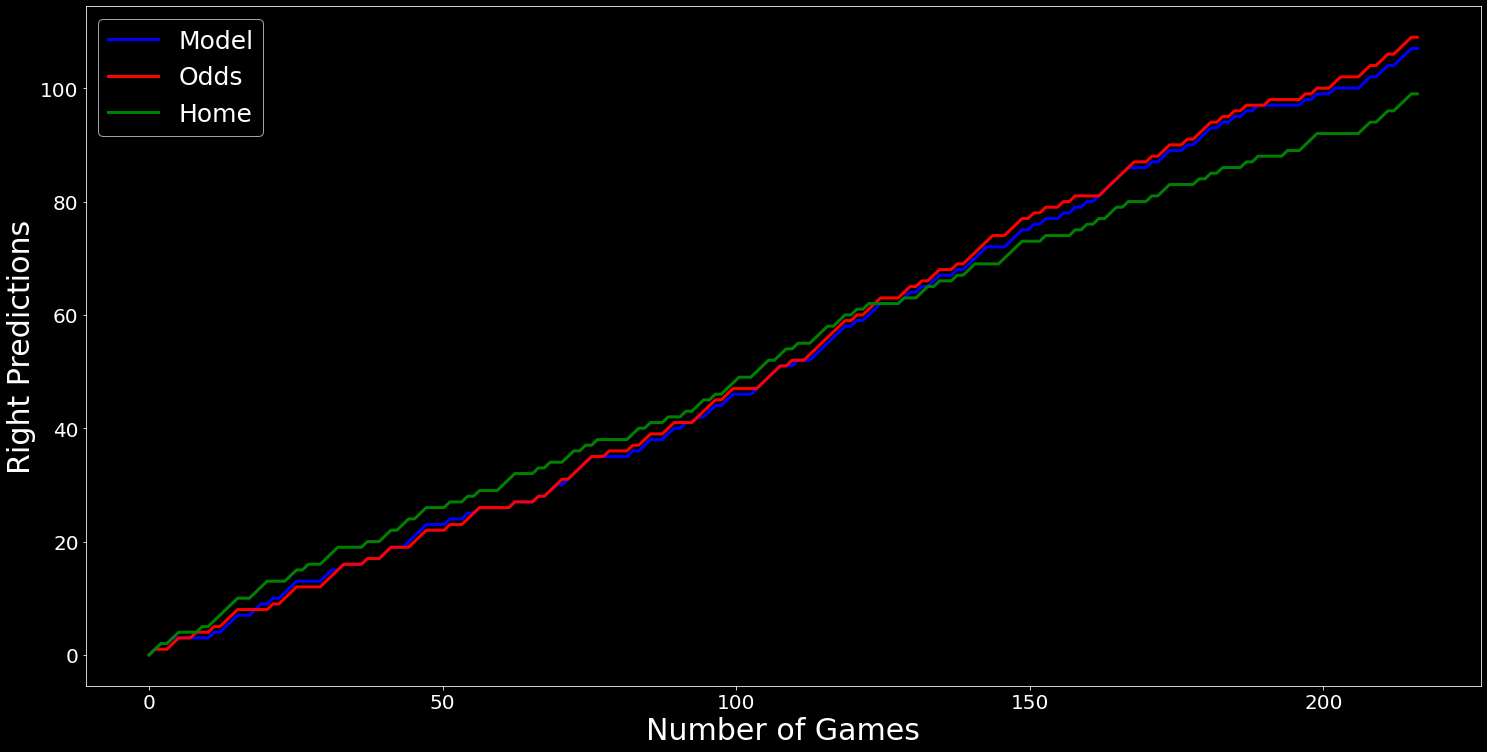

189 204
[1000, 1005.5353852, 1007.95555972, 1002.65822732, 1008.28489112, 1008.28489112, 1000.74264272, 1000.74264272, 1000.74264272, 992.4500982200001, 987.2735262200001, 992.8927126400001, 984.4390401400001, 987.8017221400002, 991.4714637400002, 994.1977543000002, 988.7023613000001, 979.6119793000001, 983.5918591000001, 983.5918591000001, 978.8095811000001, 978.8095811000001, 971.7928174000001, 976.5855733600001, 981.5956279600001, 985.24811536, 976.5853283600001, 970.53785186, 966.3760111600001, 966.3760111600001, 970.6355341600001, 974.6921995600001, 968.8719651600001, 972.7034124, 972.7034124, 964.0613010000001, 959.7011965, 965.2663813, 960.3632583, 960.3632583, 963.2948463, 968.3361333, 959.9825143, 959.9825143, 963.1449391, 968.1329946999999, 972.8311296999999, 975.8678358999998, 967.0315858999999, 960.8710588999999, 953.3556552999999, 957.9187826799999, 950.72515568, 950.72515568, 956.3598726799999, 951.8196381799999, 956.7725556199998, 956.7725556199998, 951.0203036199998, 94

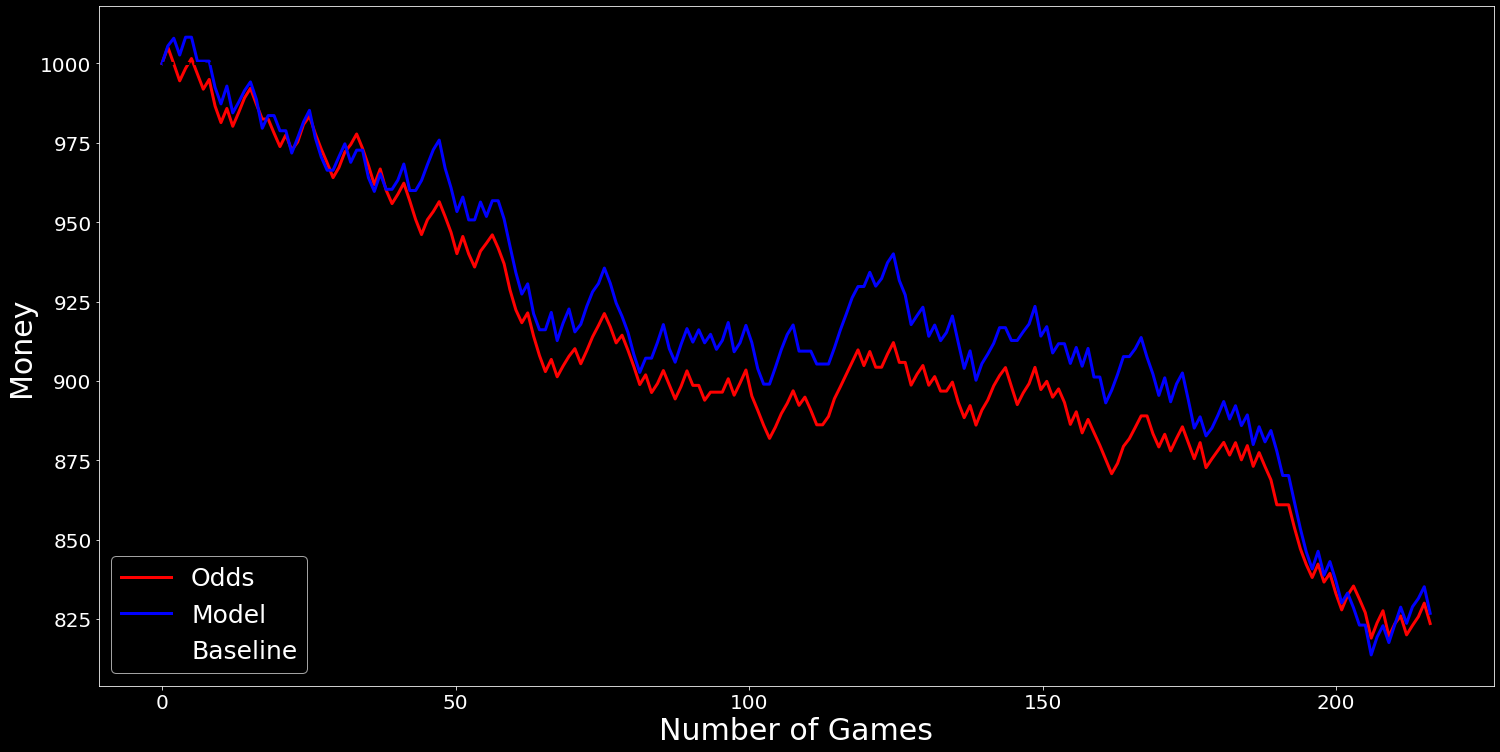

In [270]:
file1 = 'match_data_predicted_bl_22.csv'
file2 = 'dataframe_with_odd_predictions_v2.csv'
run_all(file1, file2, betting_prob=0.4)

      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


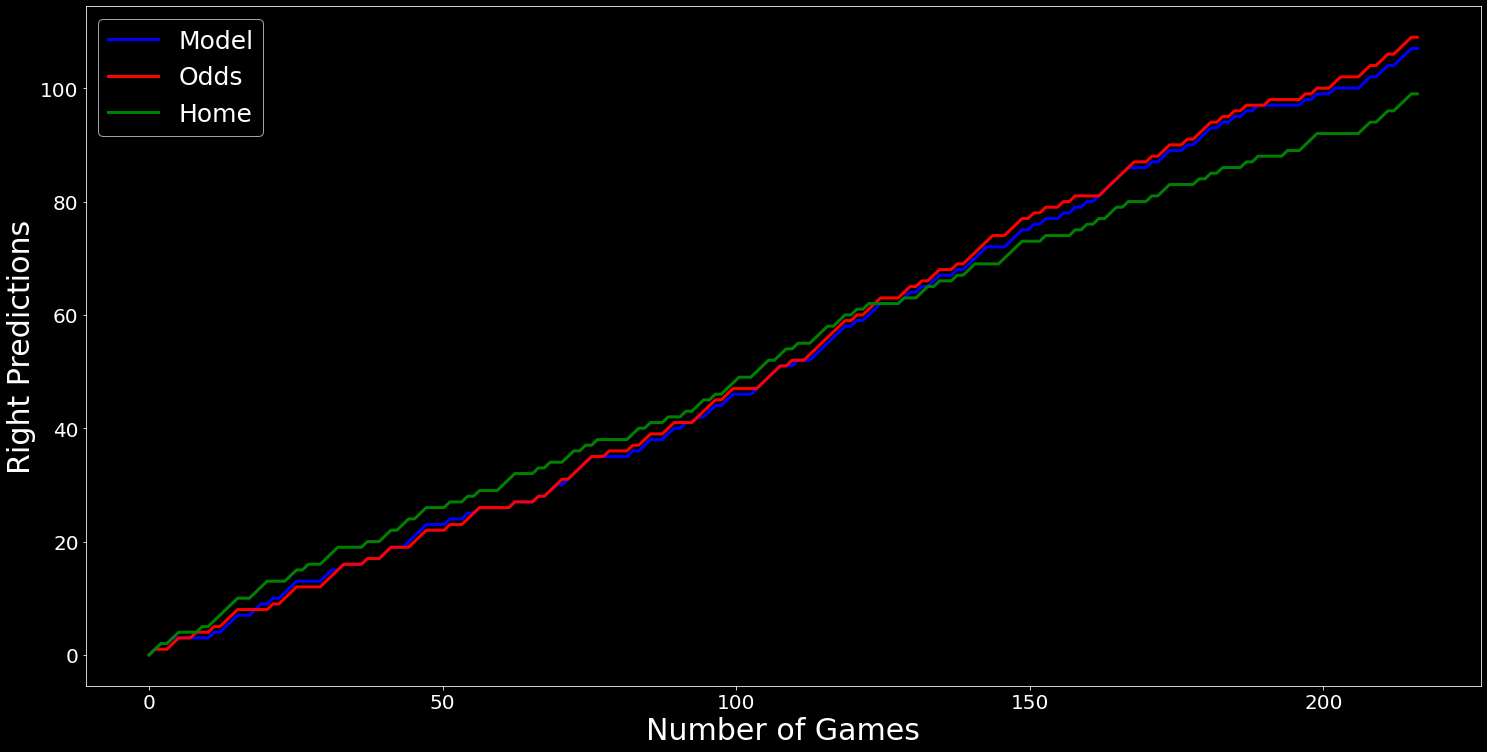

189 204
[1000, 1005.5353852, 1007.95555972, 1002.65822732, 1008.28489112, 1008.28489112, 1000.74264272, 1000.74264272, 1000.74264272, 992.4500982200001, 987.2735262200001, 992.8927126400001, 984.4390401400001, 987.8017221400002, 991.4714637400002, 994.1977543000002, 988.7023613000001, 979.6119793000001, 983.5918591000001, 983.5918591000001, 978.8095811000001, 978.8095811000001, 971.7928174000001, 976.5855733600001, 981.5956279600001, 985.24811536, 976.5853283600001, 970.53785186, 966.3760111600001, 966.3760111600001, 970.6355341600001, 974.6921995600001, 968.8719651600001, 972.7034124, 972.7034124, 964.0613010000001, 959.7011965, 965.2663813, 960.3632583, 960.3632583, 963.2948463, 968.3361333, 959.9825143, 959.9825143, 963.1449391, 968.1329946999999, 972.8311296999999, 975.8678358999998, 967.0315858999999, 960.8710588999999, 953.3556552999999, 957.9187826799999, 950.72515568, 950.72515568, 956.3598726799999, 951.8196381799999, 956.7725556199998, 956.7725556199998, 951.0203036199998, 94

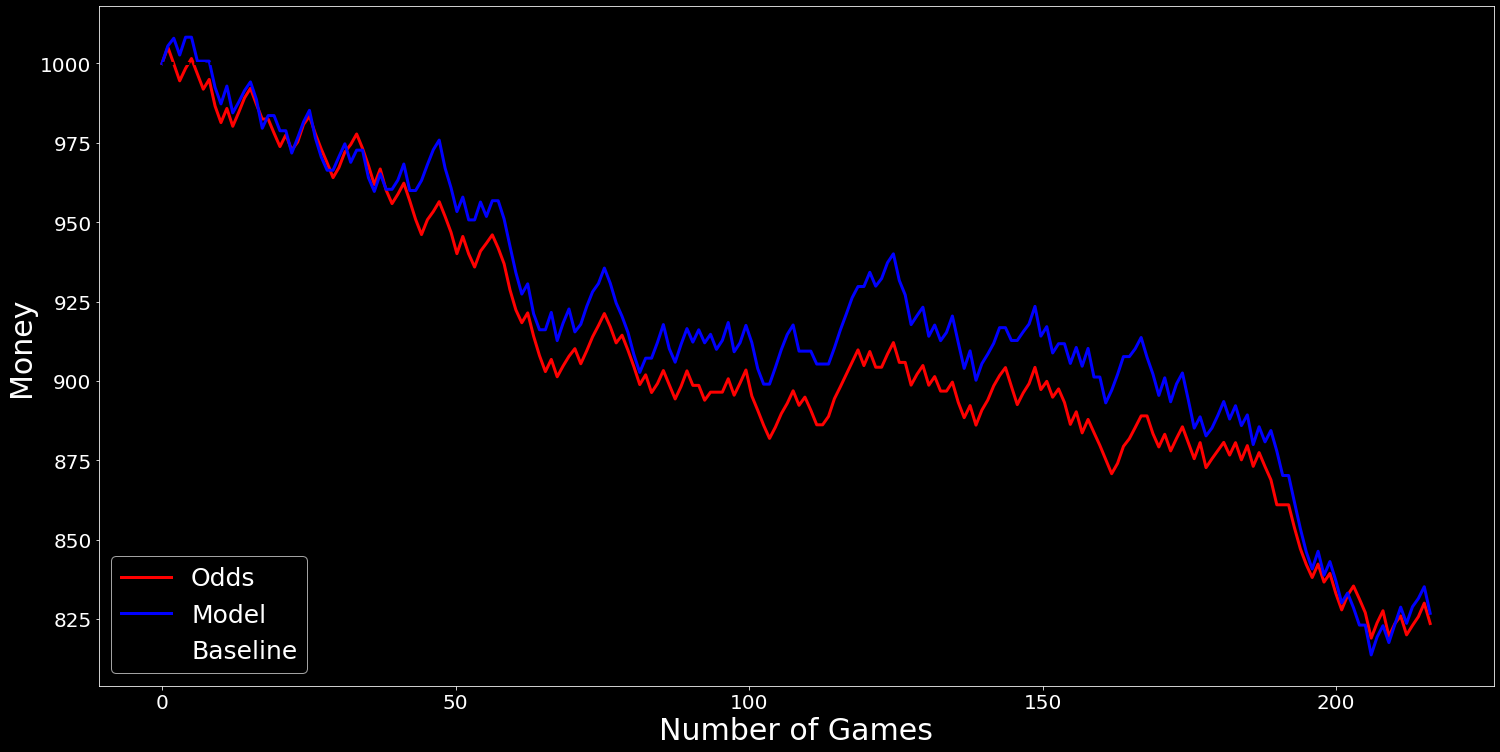

In [271]:
file1 = 'match_data_predicted_bl_22.csv'
file2 = 'dataframe_with_odd_predictions_v2.csv'
run_all(file1, file2, betting_prob=0.4)

In [272]:
simulation = []
for i in [0, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]:
    file1 = 'match_data_predicted_bl_22.csv'
    file2 = 'dataframe_with_odd_predictions_v2.csv'
    list_values = run_all(file1, file2, betting_prob=i, print_diagrams=False)
    simulation.append(list_values)

      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA  Ma

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

35 3
      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAH

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


0 0
      Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0 Div        Date       HomeTeam  \
0                0             0           0  D1    10/08/07      Stuttgart   
1                1             1           1  D1    11/08/07  Bayern Munich   
2                2             2           2  D1    11/08/07         Bochum   
3                3             3           3  D1    11/08/07  Ein Frankfurt   
4                4             4           4  D1    11/08/07       Hannover   
...            ...           ...         ...  ..         ...            ...   
4585          4585          4585         301  D1  14/05/2022          Mainz   
4586          4586          4586         302  D1  14/05/2022     M'gladbach   
4587          4587          4587         303  D1  14/05/2022      Stuttgart   
4588          4588          4588         304  D1  14/05/2022   Union Berlin   
4589          4589          4589         305  D1  14/05/2022      Wolfsburg   

           AwayTeam  FTHG  FTAG FTR  ...  PCAHA

C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3005159744.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betting_odds_data_reduced[
C:\Users\Phili\AppData\Local\Temp/ipykernel_50792/3595507598.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data_reduced[


In [273]:
from pprint import pprint
print("\n".join(simulation))

Betting Prob: 0: 
 Money at the end: 
 Odds: 820.3640278414223 
 Model: 767.2186462600006
 made bets Odds 216 
 Model: 216
Betting Prob: 0.35: 
 Money at the end: 
 Odds: 820.3640278414223 
 Model: 767.2186462600006
 made bets Odds 216 
 Model: 216
Betting Prob: 0.4: 
 Money at the end: 
 Odds: 823.5890269730164 
 Model: 826.8036538000008
 made bets Odds 204 
 Model: 189
Betting Prob: 0.45: 
 Money at the end: 
 Odds: 883.9627606967829 
 Model: 836.772340260001
 made bets Odds 161 
 Model: 169
Betting Prob: 0.5: 
 Money at the end: 
 Odds: 962.0699309324675 
 Model: 858.6987232600007
 made bets Odds 127 
 Model: 150
Betting Prob: 0.55: 
 Money at the end: 
 Odds: 1007.5985700947724 
 Model: 898.1654580400008
 made bets Odds 99 
 Model: 133
Betting Prob: 0.6: 
 Money at the end: 
 Odds: 1057.5895570105217 
 Model: 897.9181738600006
 made bets Odds 79 
 Model: 117
Betting Prob: 0.65: 
 Money at the end: 
 Odds: 1058.9519922479662 
 Model: 928.7693053800006
 made bets Odds 58 
 Model: 104